# Import thư viện

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn import set_config
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
set_config() # Để trực quan hóa pipeline
warnings.filterwarnings('ignore')


# I. Xử lý dữ liệu đầu vô

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Đọc dữ liệu

In [3]:
data_df = pd.read_csv('/train.csv')
data_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,0,no,northwest,2352.96845
1,28,female,26.510,2,no,southeast,4340.44090
2,51,male,39.700,1,no,southwest,9391.34600
3,47,male,36.080,1,yes,southeast,42211.13820
4,46,female,28.900,2,no,southwest,8823.27900
5,63,female,26.220,0,no,northwest,14256.19280
6,38,female,19.950,2,no,northeast,7133.90250
7,28,female,26.315,3,no,northwest,5312.16985
8,25,male,26.800,3,no,southwest,3906.12700
9,18,female,30.115,0,no,northeast,2203.47185


## 2. Khám phá dữ liệu

### Kiểu dữ liệu của các thuộc tính

In [4]:
data_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

### Dữ liệu có bị thiếu hay không 

In [5]:
data_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Thống kê các thuộc tính số

In [6]:
data_df.describe()

,age,bmi,children,charges
count,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.255234,30.511780,1.104686,13267.935817
std,14.039105,6.013107,1.204619,12051.356547
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.210000,0.000000,4780.839400
50%,39.000000,30.200000,1.000000,9447.382400
75%,51.000000,34.430000,2.000000,16840.667970
max,64.000000,53.130000,5.000000,62592.873090


# II. Trực quan dữ liệu và trình bày các thông tin hữu ích (insights) 

### Heatmap thể hiện sự tương quan giữa các thuộc tính

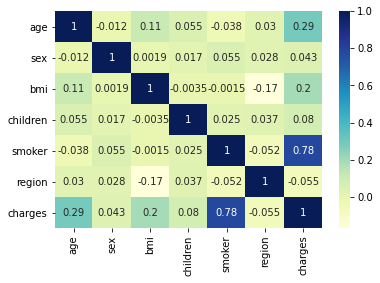

In [7]:
corr = data_df.copy()
corr.replace(['female','male'],[0,1],inplace=True)
corr.replace(['no','yes'],[0,1],inplace=True)
corr.replace(['0','1','2','3','4','5'],[0,1,2,3,4,5],inplace=True)
corr.replace(['southeast','northeast','southwest','northwest'],[0,1,2,3],inplace=True)

sns.heatmap(corr.corr(), annot=True, cbar=True, cmap='YlGnBu')
plt.show()

- **Ta thấy những màu xanh đậm hơn thể hiện sự tương quan mạnh hơn giữa các thuộc tính**

### Cái nhìn tổng quan về dữ liệu

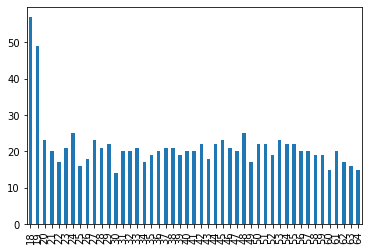

In [8]:
data_df['age'].value_counts().sort_index().plot.bar()

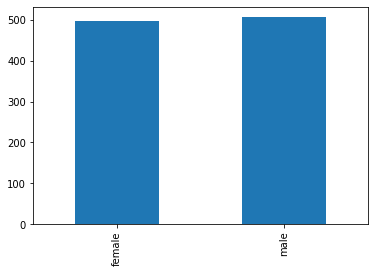

In [9]:
data_df['sex'].value_counts().sort_index().plot.bar()

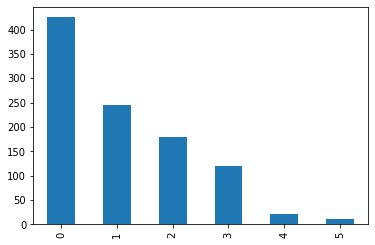

In [10]:
data_df['children'].value_counts().sort_index().plot.bar()

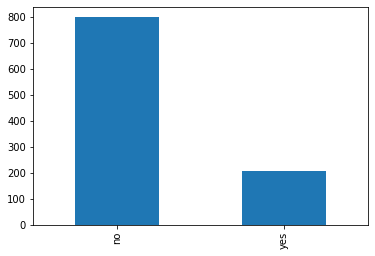

In [11]:
data_df['smoker'].value_counts().sort_index().plot.bar()

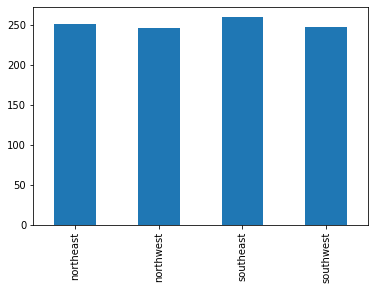

In [12]:
data_df['region'].value_counts().sort_index().plot.bar()

In [13]:
data_df.describe()

,age,bmi,children,charges
count,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.255234,30.511780,1.104686,13267.935817
std,14.039105,6.013107,1.204619,12051.356547
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.210000,0.000000,4780.839400
50%,39.000000,30.200000,1.000000,9447.382400
75%,51.000000,34.430000,2.000000,16840.667970
max,64.000000,53.130000,5.000000,62592.873090


In [14]:
data_df.isna().sum()   #missing

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

- Vùng miền nào có chi phí nhiều nhất và vùng nào có chi phí từng người cao nhất.

In [15]:
data_df.groupby('region')['charges'].sum().sort_values()

region
northwest    3.108129e+06
southwest    3.124289e+06
northeast    3.358865e+06
southeast    3.716457e+06
Name: charges, dtype: float64

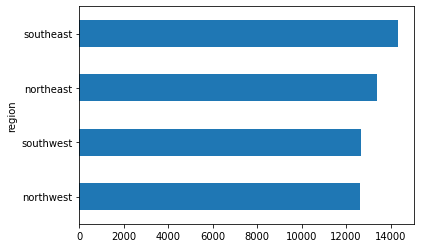

In [16]:
data_df.groupby('region')['charges'].mean().sort_values().plot.barh()

## Đầu tiên ta hãy quan sát sự phân bố của charges như thế nào?

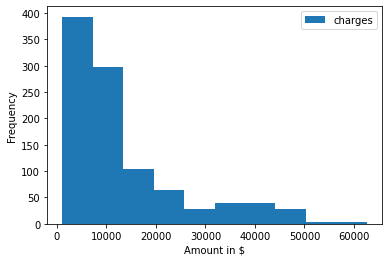

In [17]:
data_df.charges.plot(kind='hist')
plt.xlabel('Amount in $')
plt.legend()
plt.show()

- **Từ đồ thị ta có thể nhận thấy phần lớn chi phí y tế rơi vào khoảng 1000 - 13500 dollar**

### Age có ảnh hưởng như thế nào đến sự phân phối của Charges?

- Min(age) = 18
- Max(age) = 64
- Dự đoán: ở độ tuổi 18 đang là độ tuổi phát triển và khỏe mạnh nhất thế chi phí y tế bỏ ra cũng có thể ít.
- Ta sẽ xem xét sự phân phối của **Charges** với **age = 18** và **age > 18** sẽ như thế nào?

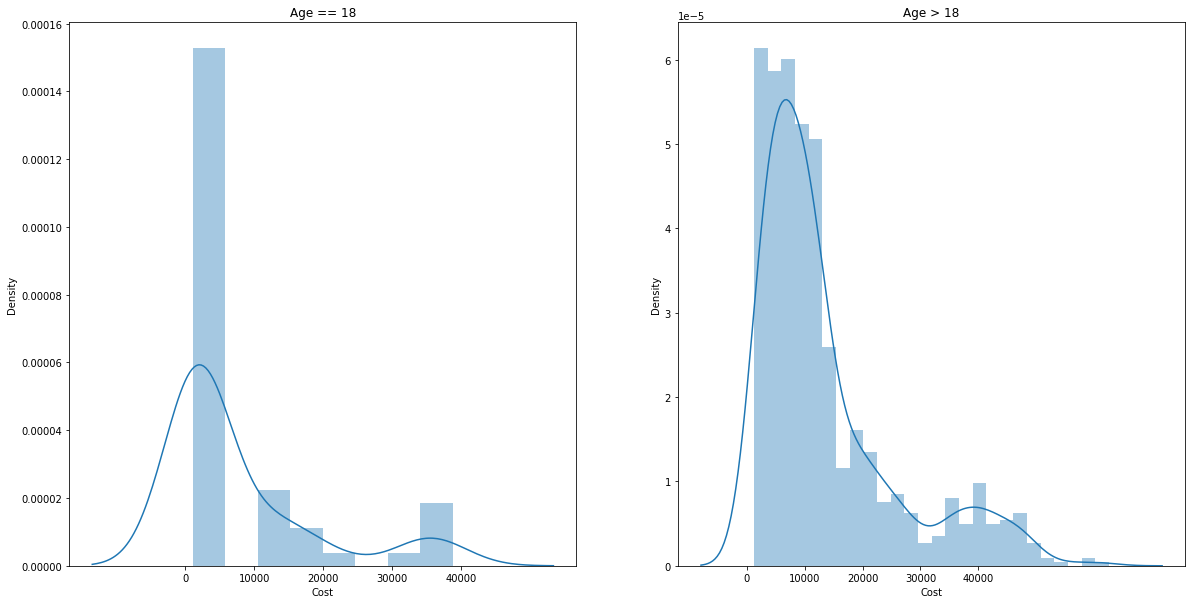

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax = sns.distplot(data_df['charges'][data_df['age'] == 18])
plt.title('Age == 18')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')

ax = fig.add_subplot(122)
ax = sns.distplot(data_df['charges'][data_df['age'] > 18])
plt.title('Age > 18')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')


plt.show()

- **Nhận xét:**
    - Với **age = 18** thì phân phối của charges có giá trị trung bình khoảng 3000 
    - Với **age > 18** thì phân phối của charges có giá trị trung bình khoảng 8500

### Smoker có ảnh hưởng như thế nào đến charges?

- **Số lượng người hút thuốc và không hút thuốc là bao nhiêu?**

In [19]:
data_df['smoker'].value_counts()

no     797
yes    206
Name: smoker, dtype: int64

Text(0, 0.5, 'Frequency')

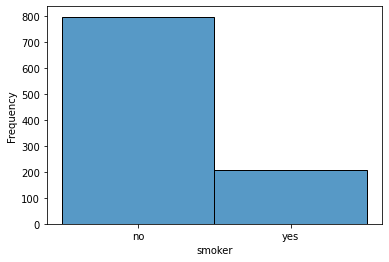

In [20]:
sns.histplot(data=data_df, x="smoker", binwidth=3,discrete = True)
plt.ylabel('Frequency')

- **Nhận xét:** ta thấy số lượng người không hút thuốc cao gấp 3 lần số lượng người hút thuốc

- **Sự tương quan giữa smoker với charges**

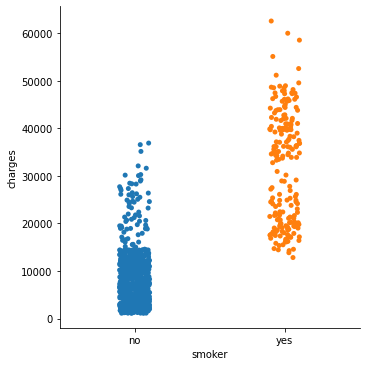

In [21]:
sns.catplot(x='smoker', y='charges', data=data_df)
plt.show()

- **Nhận xét:** 
    - Nhìn vào đồ thị ta có thể thấy người hút thuốc sẽ phải tốn nhiều chi phí y tế hơn so với người không hút thuốc.
    - Thế nên **smoker có tương quan mạnh đối với charges**


### Sự tương quan giữa smoker, sex và charges

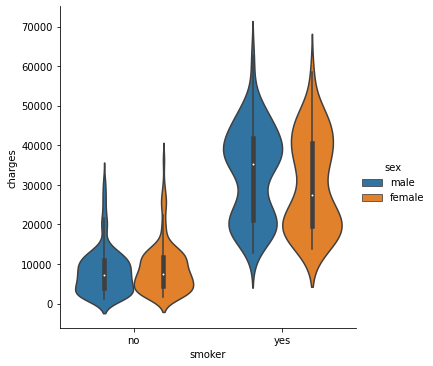

In [22]:
sns.catplot(x='smoker', y='charges',hue='sex', kind='violin',data=data_df)
plt.show()

- **Nhận xét:** 
    - Ở phần trên ta có thể thấy **smoker = yes** thì chi phí y tế sẽ phải trả nhiều hơn
    - **Bất kì giới tính nào nếu hút thuốc thì đều phải tốn nhiều chi phí y tế hơn**
    - Khi thêm thuộc tính **sex** vào thì cũng không có sự thay đổi gì.
    - Chưa nhận thấy được sự tương quan mạnh giữa **sex** với **charges**

### Sự tương quan giữa smoker, sex, age và charges

- **Xét trường hợp age = 18**

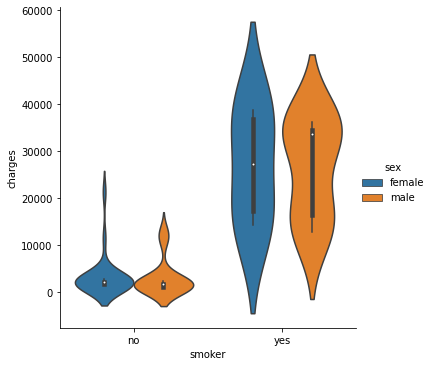

In [23]:
sns.catplot(x='smoker', y='charges',hue='sex', kind='violin',data=data_df[data_df['age'] == 18])
plt.show()

- **Xét trường hợp age > 18**

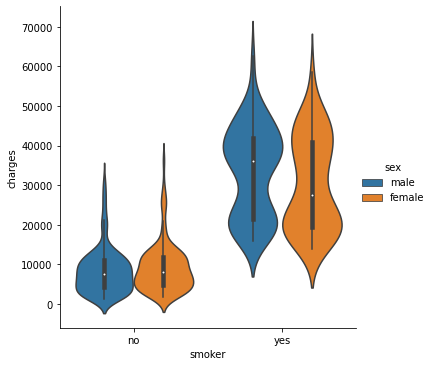

In [24]:
sns.catplot(x='smoker', y='charges',hue='sex', kind='violin',data=data_df[data_df['age'] > 18])
plt.show()

- **Nhận xét:** không có sự khác biệt đáng kể nào, bất kì giới tính hay lứa tuổi nào nếu hút thuốc thì sẽ phải tốn nhiều chi phí y tế hơn

### Sự tương quan giữa BMI và charges

- **Xét sự phân phối của chỉ số BMI**

Text(0.5, 0, 'BMI')

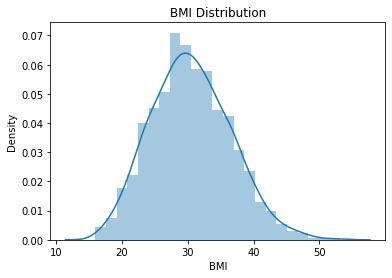

In [25]:
sns.distplot(data_df['bmi'])
plt.title('BMI Distribution')
plt.xlabel('BMI')

- **Nhận xét:** ta thấy **BMI** trung bình rời vào khoảng 30 điều này thật sự không tốt
- Theo **WHO** ta có thể chia thang đo BMI thành 4 loại như sau:
    - 1. Underweight - BMI < 18.5
    - 2. Normal - BMI >= 18.5 and BMI < 24.9
    - 3. Overweight - BMI >= 24.9 and BMI < 29.9
    - 4. Obese - BMI >= 30

- **Xét sự tương quan giữa BMI với charges**

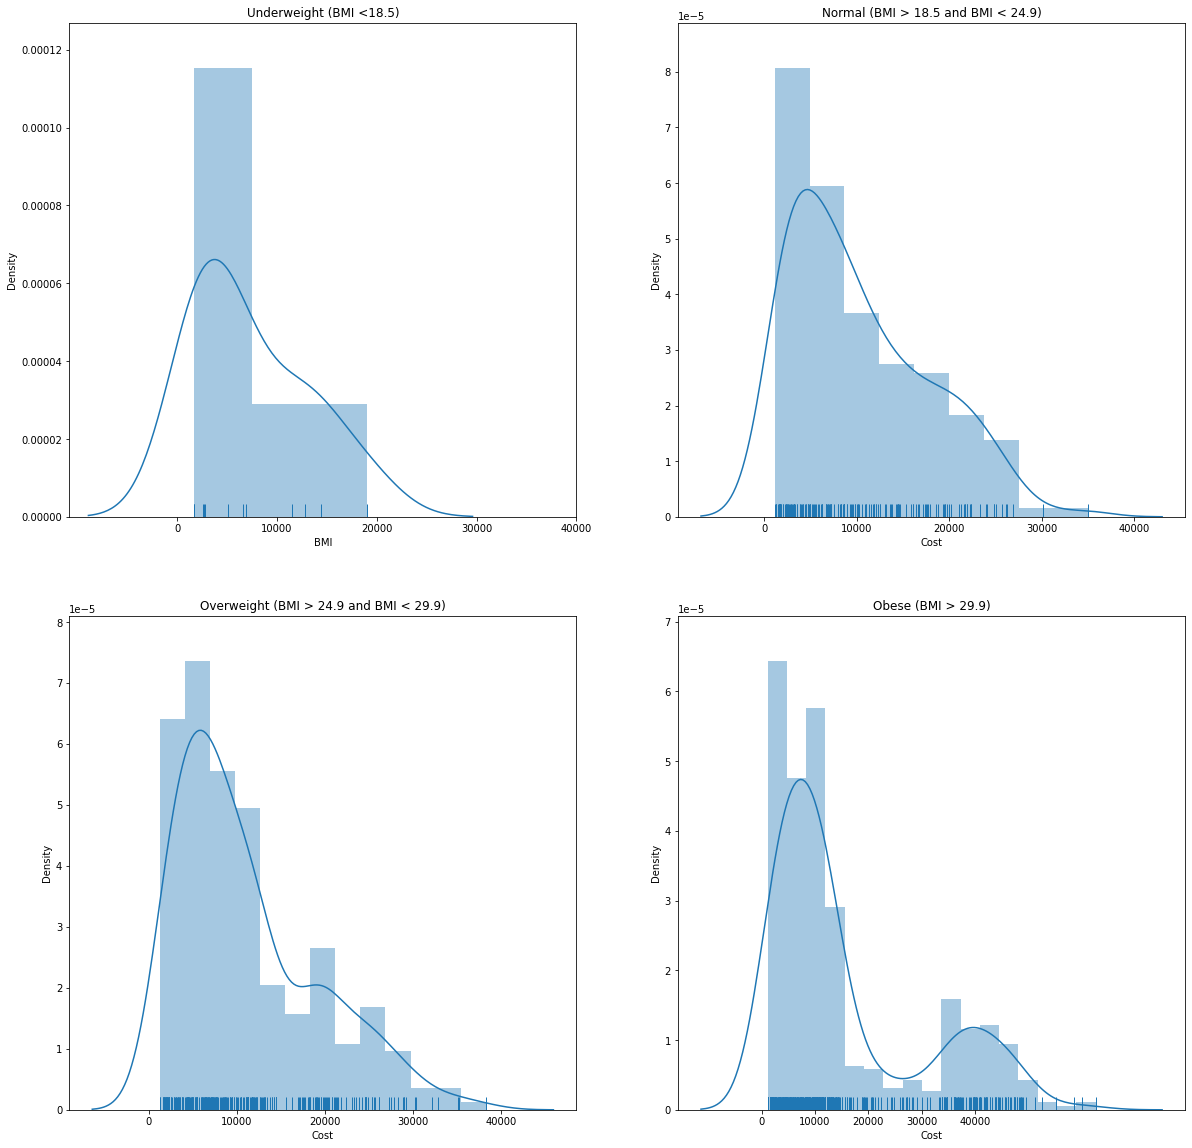

In [26]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(221)
ax = sns.distplot(data_df['charges'][data_df['bmi'] < 18.5], rug=True)
plt.title('Underweight (BMI <18.5)')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('BMI')


ax = fig.add_subplot(222)
ax = sns.distplot(data_df['charges'][(data_df['bmi'] >= 18.5) & (data_df['bmi'] < 24.9)], rug=True)
plt.title('Normal (BMI > 18.5 and BMI < 24.9)')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')


ax = fig.add_subplot(223)
ax = sns.distplot(data_df['charges'][(data_df['bmi'] >= 24.9) & (data_df['bmi'] < 29.9)], rug=True)
plt.title('Overweight (BMI > 24.9 and BMI < 29.9)')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')


ax = fig.add_subplot(224)
ax = sns.distplot(data_df['charges'][data_df['bmi'] > 29.9], rug=True)
plt.title('Obese (BMI > 29.9)')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')


plt.show()

- **Nhận xét:**
    - Hình dáng đồ thì có sự thay đổi ở sườn bên phải
    - Chi phí sẽ tăng nhẹ đối với mỗi loại **BMI** khác nhau

### Sự tương quan giữa BMI, Smoker, Charges

In [27]:
smoker_yes = data_df[['bmi','charges']][data_df['smoker'] == 'yes']
smoker_no = data_df[['bmi','charges']][data_df['smoker'] == 'no']

Text(0.5, 0, 'BMI')

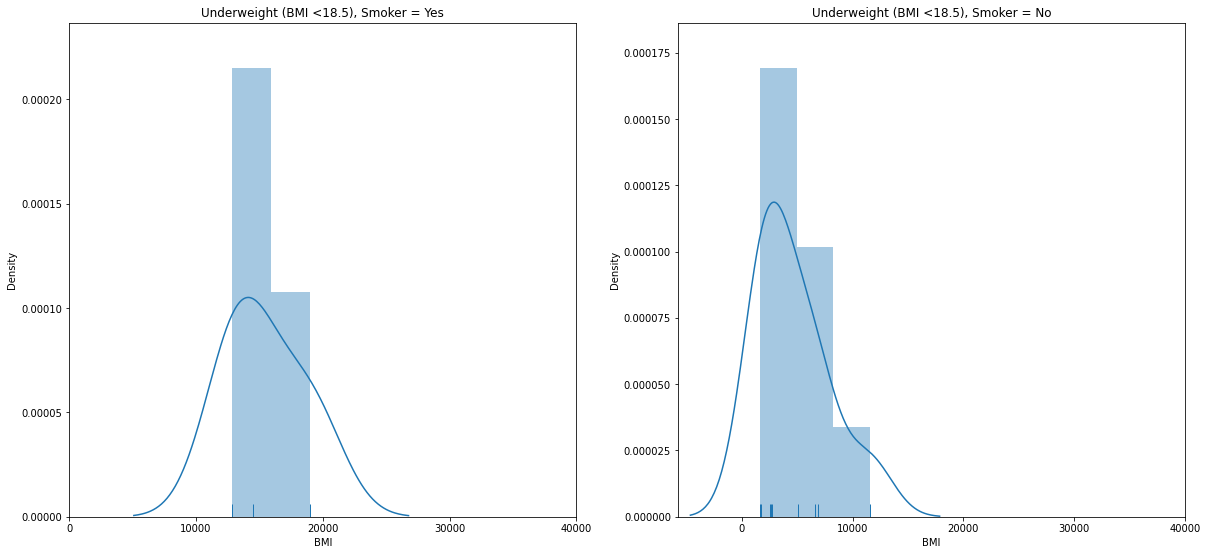

In [28]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(221)
sns.distplot(smoker_yes['charges'][smoker_yes['bmi'] < 18.5], rug=True)
plt.title('Underweight (BMI <18.5), Smoker = Yes')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('BMI')

ax = fig.add_subplot(222)
sns.distplot(smoker_no['charges'][smoker_no['bmi'] < 18.5], rug=True)
plt.title('Underweight (BMI <18.5), Smoker = No')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('BMI')


Text(0.5, 0, 'Cost')

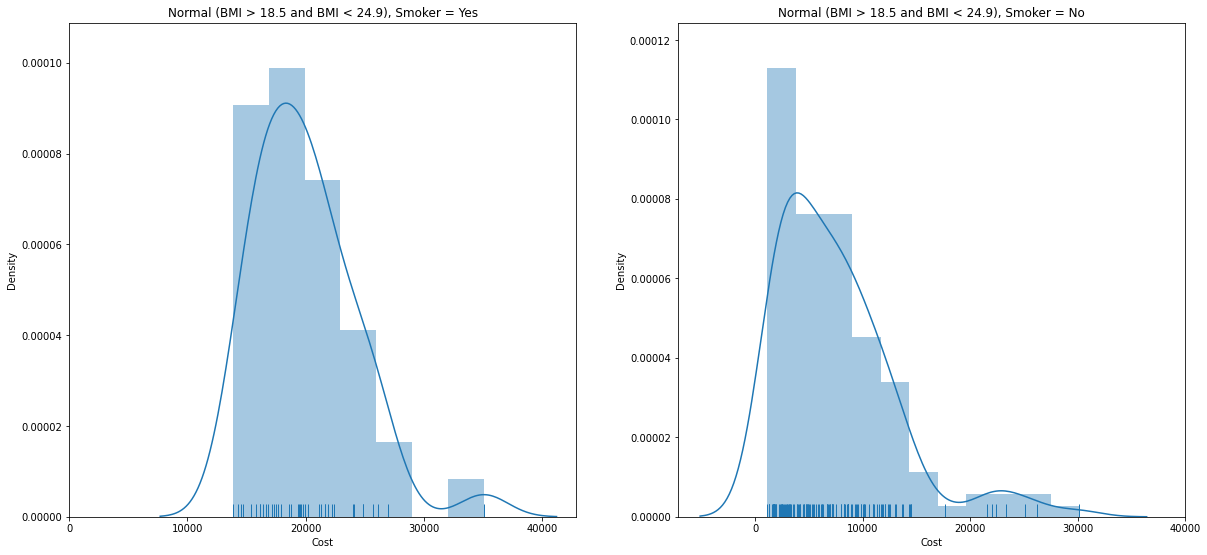

In [29]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(221)
ax = sns.distplot(smoker_yes['charges'][(smoker_yes['bmi'] >= 18.5) & (smoker_yes['bmi'] < 24.9)], rug=True)
plt.title('Normal (BMI > 18.5 and BMI < 24.9), Smoker = Yes')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')

ax = fig.add_subplot(222)
ax = sns.distplot(smoker_no['charges'][(smoker_no['bmi'] >= 18.5) & (smoker_no['bmi'] < 24.9)], rug=True)
plt.title('Normal (BMI > 18.5 and BMI < 24.9), Smoker = No')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')

Text(0.5, 0, 'Cost')

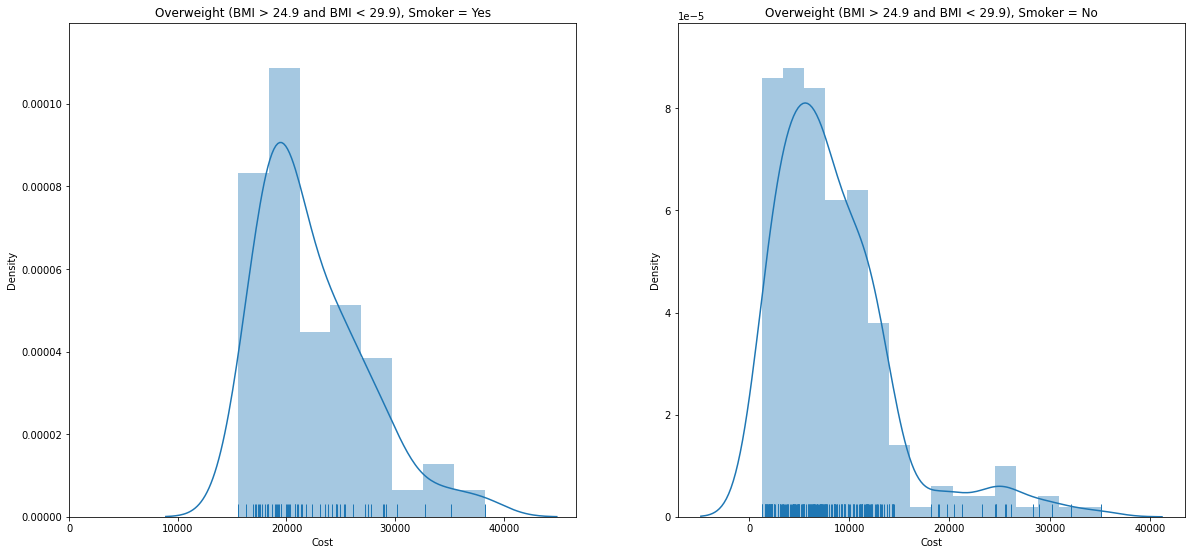

In [30]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(221)
ax = sns.distplot(smoker_yes['charges'][(smoker_yes['bmi'] >= 24.9) & (smoker_yes['bmi'] < 29.9)], rug=True)
plt.title('Overweight (BMI > 24.9 and BMI < 29.9), Smoker = Yes')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')


ax = fig.add_subplot(222)
ax = sns.distplot(smoker_no['charges'][(smoker_no['bmi'] >= 24.9) & (smoker_no['bmi'] < 29.9)], rug=True)
plt.title('Overweight (BMI > 24.9 and BMI < 29.9), Smoker = No')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')

Text(0.5, 0, 'Cost')

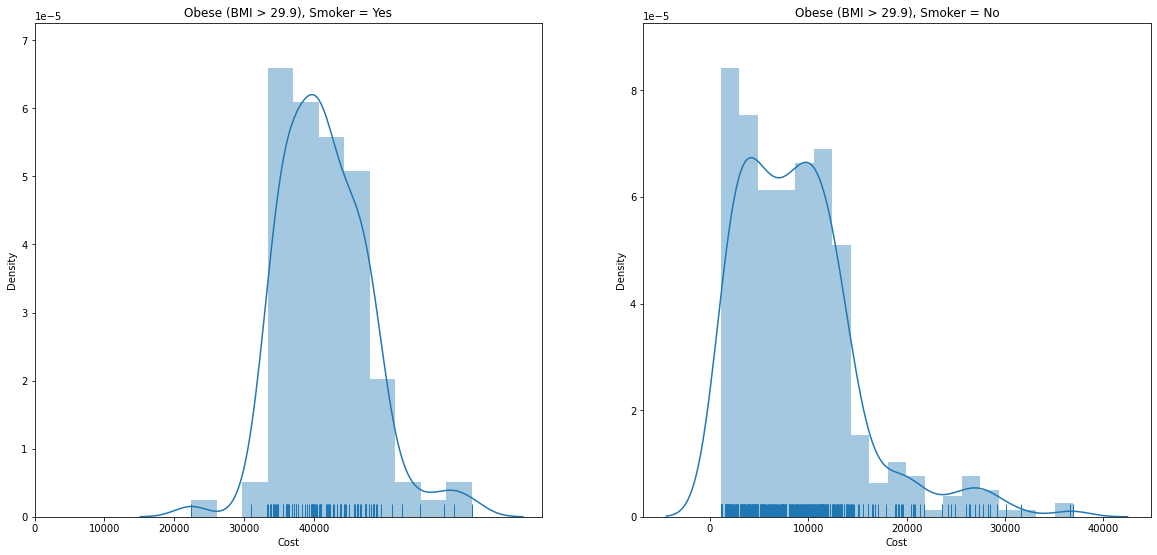

In [31]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(221)
ax = sns.distplot(smoker_yes['charges'][smoker_yes['bmi'] > 29.9], rug=True)
plt.title('Obese (BMI > 29.9), Smoker = Yes')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')


ax = fig.add_subplot(222)
ax = sns.distplot(smoker_no['charges'][smoker_no['bmi'] > 29.9], rug=True)
plt.title('Obese (BMI > 29.9), Smoker = No')
plt.xticks(np.arange(0,50000,10000))
plt.xlabel('Cost')

- **Nhận xét:** bất kì chỉ số **BMI** như thế nào nếu **có hút thuốc** thì sẽ phải trả nhiều chi phí y tế hơn

### Sự tương quan giữa Smoker và Children

- **Dự đoán:** thông thường nếu gia đình có trẻ con thì người lớn sẽ ít hút thuốc hơn vì sợ ảnh hưởng đến sức khỏe của trẻ nhỏ.

In [32]:
data_df.groupby('children')['smoker'].value_counts()

children  smoker
0         no        342
          yes        83
1         no        201
          yes        45
2         no        136
          yes        43
3         no         88
          yes        32
4         no         19
          yes         2
5         no         11
          yes         1
Name: smoker, dtype: int64

In [33]:
smoker_children = pd.DataFrame([[0,0,342],
                                [1,0,201],
                                [2,0,136],
                                [3,0,88],
                                [4,0,19],
                                [5,0,11],
                                [0,1,83],
                                [1,1,45],
                                [2,1,43],
                                [3,1,32],
                                [4,1,2],
                                [5,1,1]],columns=['children','smoker','count'])

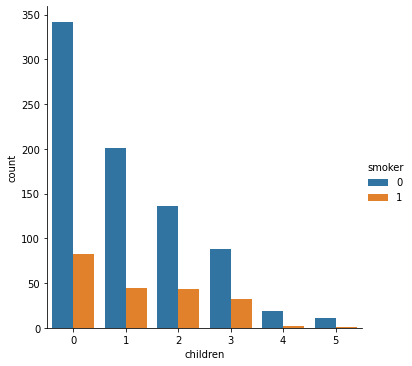

In [34]:
sns.catplot(x='children', y='count', hue='smoker', kind='bar', data=smoker_children)
plt.show()

- **Nhận xét:** ta thấy số children càng lớn thì số smoker càng giảm

### Sự tương quan giữa Smoker, Children và Charges

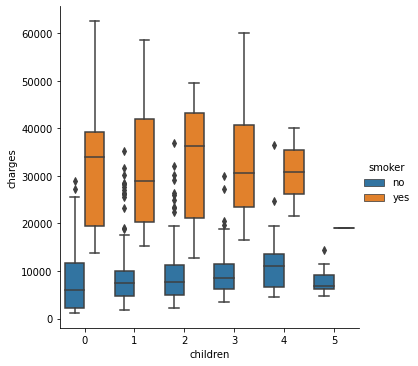

In [35]:
sns.catplot(x='children', y='charges', hue='smoker', kind='box', data=data_df)
plt.show()

- **Nhận xét:** ta có thể thấy bất kể nó bao nhiêu **children** đi nữa nếu **hút thuốc** thì sẽ phải tốn nhiều chi phí y tế hơn

### Sự tương quan giữa Region và Charges

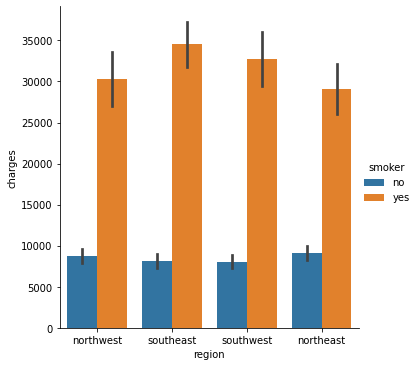

In [36]:
sns.catplot(x='region', y='charges', hue='smoker', kind='bar', data=data_df)
plt.show()

- **Nhận xét:** 
    - Vùng miền không ảnh hưởng nhiều đến charges
    - Ở **southeast** sẽ nhiều hơn các vùng còn lại một tí

### Kết luận phần trực quan và insight

- **Những yếu tố quan trọng quyết định đến chi phí y tế:**
    - **Smoker: một người có hút thuốc hay không**
    - **Age: tuổi tác, tuổi tác càng già thì cần được chăm sóc y tế nhiều hơn**
    - **BMI: chỉ số BMI càng lớn(>30) có nguy cơ béo phì nên chi phí y tế sẽ tăng**
- **Những yếu tố như Region, Children, Sex không ảnh hưởng nhiều đến việc tăng giảm chi phí y tế**

# III. Tiền xử lý 

# 1. Tách tập train và tập validation ra theo tỉ lệ: 70%:30%.¶


- Tách thành 2 phần X và y. Với X là input, y là output, với y là `charges`

In [37]:
# Tách X và y
y_sr = data_df["charges"] # sr là viết tắt của series
X_df = data_df.drop("charges", axis=1)

- Chia thành 2 bộ dữ liệu train và validation

In [38]:
train_X, val_X, train_y, val_y = train_test_split(X_df,y_sr,test_size=0.3, random_state=0)

- Kích thước dữ liệu sau khi tách

In [39]:
print("shape train_X :", train_X.shape)
print("shape train_y :", train_y.shape)
print("shape val_X :", val_X.shape)
print("shape val_y :", val_y.shape)

shape train_X : (702, 6)
shape train_y : (702,)
shape val_X : (301, 6)
shape val_y : (301,)


## 2.  Khám phá dữ liệu (Tập huấn luyện)

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [40]:
train_X.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object

- Nhận xét về tập dữ liệu
    - Dữ liệu có 6 thuộc tính.
    - Các thuộc tính có kiểu dữ liệu có vẻ phù hợp.

## 3. Tiền xử lý (tập huấn luyện)

Ta tiến hành tiền xử lý như sau: 
- Như đã phân tích các nhân tố của từng thuộc tính ảnh hưởng đến mức độ chi phí, do đó ta sẽ sắp xếp và chuyển đổi các nhân tố  của từng thuộc tính đó theo thứ tự dạng numeric, tùy theo độ mức độ ảnh hưởng.
- Ở đây, ví dụ: Với thuộc tính `smoker`, sau khi phân tích ở trên, ta có thể nhận thấy chi phí trung bình của người có hút thuốc cao gấp 4 lần so với người không hút thuốc nên chuyển `yes` sang 4 và `no` sang 1. Tương tự cho các thuộc tính khác, sẽ được chuyển đổi sao cho phù hợp.

In [41]:
def convert_col_dtype(col):
    if col.name == 'smoker':
        col.replace('yes',4, inplace = True)
        col.replace('no',1, inplace = True)
 #   if col.name == 'region':
 #       col.replace('northwest',1, inplace = True)
 #       col.replace('southwest',2, inplace = True)
 #       col.replace('northeast',3, inplace = True)
 #       col.replace('southeast',4, inplace = True)
 #   if col.name == 'sex':
 #       col.replace('male',2, inplace = True)
 #       col.replace('female',1, inplace = True)
    if col.name == 'children':
        col.replace(3,6, inplace = True)
        col.replace(2,5, inplace = True)
        col.replace(4,4, inplace = True)
        col.replace(1,3, inplace = True)
        col.replace(0,2, inplace = True)
        col.replace(5,1, inplace = True)
    return col

- Class `ColAdderDropper` ở dưới đây sẽ thực hiện các bước ở trên.
- Ngoài ra, class `ColAdderDropper` được kế thừa từ 2 class của Sklearn là `BaseEstimator` và `TransformerMixin`. Việc kế thừa này giúp class của ta tự động có các phương thức như `set_params`, `get_params`, `fit_transform` 

In [42]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        _df = X_df.copy()
        _df = _df.apply(convert_col_dtype)
        return _df
    
col_adderdropper = ColAdderDropper()
fewer_cols_train_X_df = col_adderdropper.fit_transform(data_df)
fewer_cols_train_X_df

,age,sex,bmi,children,smoker,region,charges
0,24,male,23.655,2,1,northwest,2352.96845
1,28,female,26.510,1,1,southeast,4340.44090
2,51,male,39.700,3,1,southwest,9391.34600
3,47,male,36.080,3,4,southeast,42211.13820
4,46,female,28.900,1,1,southwest,8823.27900
...,...,...,...,...,...,...,...
998,18,female,31.350,4,1,northeast,4561.18850
999,39,female,23.870,1,1,southeast,8582.30230
1000,58,male,25.175,2,1,northeast,11931.12525
1001,37,female,47.600,1,4,southwest,46113.51100


In [43]:
fewer_cols_train_X_df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker        int64
region       object
charges     float64
dtype: object

- Có vẽ như kiểu dữ liệu các cột khá lý tưởng.

### Các bước tiền xử lý tiếp theo như sau:

Bây giờ ta chuyển tất cả các cột về dạng số như sau:
- Do các cột không chứa các giá trị thiếu nên ta không cần điền giá trị thiếu vào.
- Với các cột dạng số, ta giữ nguyên.
- Các cột không phải dạng số  và không có thứ tự, ta sẽ mã hóa bằng `one-hot`.

Tiến hành chuẩn hóa.

Cuối cùng tạo một pipeline sử dụng các thao tác trên cùng lúc.


In [44]:
unorder_cate_cols = ['sex','region']

mode_unordercols = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

col_transform = ColumnTransformer([('unorder_cate_cols', mode_unordercols,unorder_cate_cols)],remainder='passthrough')

preprocess_pipeline = make_pipeline(col_adderdropper,col_transform,StandardScaler())
preprocessed_train_X = preprocess_pipeline.fit_transform(data_df)
preprocessed_train_X

array([[-0.99106682,  0.99106682, -0.57773402, ..., -0.39671642,
        -0.50839872, -0.9061563 ],
       [ 1.0090137 , -1.0090137 , -0.57773402, ..., -1.0863292 ,
        -0.50839872, -0.74115711],
       [-0.99106682,  0.99106682, -0.57773402, ...,  0.29289635,
        -0.50839872, -0.32183296],
       ...,
       [-0.99106682,  0.99106682,  1.73090033, ..., -0.39671642,
        -0.50839872, -0.11098149],
       [ 1.0090137 , -1.0090137 , -0.57773402, ..., -1.0863292 ,
         1.9669601 ,  2.72682672],
       [-0.99106682,  0.99106682, -0.57773402, ..., -0.39671642,
        -0.50839872, -0.25348375]])

## 4. Độ lỗi

Sử dụng độ do R-Squared cho mô hình hồi quy.

In [45]:
# Tính độ đo r^2 trên tập huấn luyện
def compute_mse(y, preds):
    return ((y - preds) ** 2).mean()
def compute_rr(y, preds, baseline_preds):
    return 1 - compute_mse(y, preds) / compute_mse(y, baseline_preds)
baseline_preds = train_y.mean()

## 5. Đọc file test

In [46]:
test_df = pd.read_csv('/test.csv')
y_sr_test = test_df["charges"] # sr là viết tắt của series
X_df_test = test_df.drop("charges", axis=1)

# IV. Tiền xử lý và áp dụng các mô hình học máy.

#### Tìm mô hình tốt nhất cho độ lỗi trên tập validation nhỏ nhất

# + MÔ HÌNH CƠ BẢN

## 1. Linear Regression 

### a. Tạo pipeline cho mô hình và huấn luyện cho mô hình

In [47]:
warnings.filterwarnings("ignore")
linear_model =LinearRegression()
linear_pipeline = make_pipeline(col_adderdropper,col_transform, StandardScaler(), linear_model)
linear_train_X_df = train_X.append(val_X)
linear_train_y_sr = train_y.append(val_y)
linear_pipeline.fit(linear_train_X_df,linear_train_y_sr)

Pipeline(memory=None,
         steps=[('coladderdropper', ColAdderDropper()),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('unorder_cate_cols',
                                                  Pipeline(memory=None,
                                                           steps=[('onehotencoder',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                        

- Đọc file test

### b. So sánh kết quả predict với kết quả thực trên tập test

In [48]:
linear_preds = linear_pipeline.predict(X_df_test).round(5)
# So sánh kết quả predict với kết quả actual
linear_preds_df = pd.DataFrame(linear_preds, index=y_sr_test.index).rename(columns={0: 'Predict'})
linear_preds_df = linear_preds_df.assign(Actual = y_sr_test)
linear_preds_df.sample(15)

,Predict,Actual
190,5473.21197,3597.59600
238,36347.80370,43896.37630
77,11775.13821,11454.02150
182,6475.65665,8428.06930
170,7771.65665,9182.17000
67,9553.21197,25992.82104
92,33604.84058,23401.30575
218,11935.13821,12629.89670
257,5883.65665,3292.52985
142,5919.13821,2322.62180


### c. Độ chính xác 

In [49]:
linear_score=compute_rr(y_sr_test, linear_preds, baseline_preds) * 100
print("Độ chính xác: ",linear_score)

Độ chính xác:  76.45592517072784


## 2. Linear Regression với Gradient Decent

- Hàm Linear

In [50]:
class GDLinearRegression:
    def __init__(self, lr, step):
        '''
        Khởi tạo learning rate và số lượng step update weigh
        '''
        self.lr = lr
        self.step = step

    def fit(self, X, y):
        ''' 
        Train the model với đầu vào là tập train data X cùng nhãn Y
        X là ma trận MxN trong đó M là số lượng điểm dữ liệu, mỗi điểm dữ liệu có N chiều.
        Trường hợp dữ liệu 1 chiều thì X là vector cột Mx1
        '''
        # lấy ra số lượng điểm train_size và số chiều dữ liệu n_features
        self.n_features = X.shape[1] if len(X.shape) > 1 else 1 
        train_size = len(X) # số lượng sample
        
        # chuẩn hóa lại định dạng dữ liệu
        X = X.reshape(-1, self.n_features)
        y= pd.DataFrame(y.values.reshape([-1, 1]))
        
        # ta muốn thực hiện dự đoán y = X.T*W + bias, ta đưa bias vào W (W|bias) và 1 cột toàn 1 vào X (X|one),
        # lúc đó việc tính toán thuận tiện hơn y = (X|one).T*(W|bias) => đây là trick để tính toán cho nhanh
        one = np.ones([train_size, 1])
        X = np.concatenate([X, one], 1)
        
        # tạo weight chính là parameters ta sẽ optimize trong quá trình train
        self.weight = np.zeros([self.n_features + 1, 1])
        print('x shape: ', X.shape, '- y shape: ', y.shape, '- weight shape: ', self.weight.shape, 'train_size: ', train_size)
        
        # mảng lưu lại toàn bộ giá trị loss trong quá trình train
        self.train_loss = []
        
        # train
        for i in range(self.step):
            
            loss = np.sum((y - np.dot(X, self.weight)) ** 2)
            delta = np.dot(X.T, ( np.dot(X, self.weight) - y))
            
            # update weight
            self.weight = self.weight - (self.lr/train_size) * delta
            
            # tính trung bình loss
            loss = loss/train_size
            self.train_loss.append(loss.item())
    
    def predict(self, X):
        '''
        Thực hiện dự đoán
        '''
        # chuẩn hóa format dữ liệu như ta đã làm trong lúc train
        X = X.reshape(-1, self.n_features)
        
        # thêm cột one như ta đã làm trong lúc train
        one = np.ones([len(X), 1])
        X = np.concatenate([X, one], 1)
        
        # thực hiện dự đoán, đơn giản là nhân ma trận
        y_hat = np.dot(X, self.weight)
        
        return np.squeeze(y_hat)
    
    def print_weight(self):
        '''
        In weigt đã học được
        '''
        print(self.weight)
        
    def get_train_loss(self):
        '''
        Trả về train loss đã lưu trong quá trình train
        '''
        return self.train_loss

### a. Tạo pipeline cho mô hình, huấn luyện cho mô hình và tìm tham số tốt nhất

In [51]:
warnings.filterwarnings("ignore")
GDLR_model = GDLinearRegression(0.1,1000)
GDLR_pipeline = make_pipeline(col_adderdropper,col_transform, StandardScaler(), GDLR_model)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
lrs = [0.001, 0.1,0.5, 1]
steps=[10,50,100,1000]
best_val_err = float('inf'); best_alpha = None; best_hidden_layer=None;
for lr in lrs:
    for step in steps:
        GDLR_pipeline[3].lr=lr
        GDLR_pipeline[3].step=step
        GDLR_pipeline.fit(train_X, train_y)
        train_errs.append(100 - compute_rr(train_y, GDLR_pipeline.predict(train_X), baseline_preds) * 100)
        val_errs.append(100 - compute_rr(val_y, GDLR_pipeline.predict(val_X), baseline_preds) * 100)

        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_lr = lr
            best_step=step

x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x shape:  (702, 11) - y shape:  (702, 1) - weight shape:  (11, 1) train_size:  702
x sh

- Tham số tốt nhất

In [52]:
print("best_lr : ", best_lr)
print("best_step : " ,best_step)

best_lr :  0.1
best_step :  1000


### b. Tạo pipeline và huấn luyện mô hình bằng tham số tốt nhất 

In [53]:
warnings.filterwarnings("ignore")
GDLR_model_best = GDLinearRegression(best_lr, best_step)
GDLR_pipeline = make_pipeline(col_adderdropper, col_transform, StandardScaler(), GDLR_model_best)

In [54]:
warnings.filterwarnings("ignore")
GDLR_train_X_df = train_X.append(val_X)
GDLR_train_y_sr = train_y.append(val_y)
GDLR_pipeline.fit(GDLR_train_X_df, GDLR_train_y_sr)

x shape:  (1003, 11) - y shape:  (1003, 1) - weight shape:  (11, 1) train_size:  1003


Pipeline(memory=None,
         steps=[('coladderdropper', ColAdderDropper()),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('unorder_cate_cols',
                                                  Pipeline(memory=None,
                                                           steps=[('onehotencoder',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                        

### c. So sánh giá trị dự đoán tập test so với thực tế 

In [55]:
GDLR_predict=GDLR_pipeline.predict(X_df_test)
GDLR_preds_df = pd.DataFrame(GDLR_predict).rename(columns={0: 'Predict'})
GDLR_preds_df = GDLR_preds_df.assign(Actual = y_sr_test)
GDLR_preds_df

,Predict,Actual
0,8618.422692,9095.06825
1,7553.169400,5272.17580
2,37488.304316,29330.98315
3,8678.596154,9301.89355
4,27476.070898,33750.29180
...,...,...
330,13328.579079,13217.09450
331,15350.853922,11944.59435
332,7451.236129,14358.36437
333,26416.273275,32548.34050


### d. Độ chính xác mô hình

In [56]:
GDLR_score=compute_rr(y_sr_test, GDLR_predict, baseline_preds) * 100
print("Độ chính xác linear Regression với Gradient Decent: ",GDLR_score)

Độ chính xác linear Regression với Gradient Decent:  76.39518336884825


# + MÔ HÌNH NÂNG CAO

-  DO ĐÂY LÀ **BÀI TOÁN HỒI QUY** NÊN CÁC MÔ HÌNH MÁY HỌC ĐƯỢC XÉT:
    - `RandomForestRegressor`
    - `MLPRegressor`

## 1. Mô hình `MLPRegressor`

Ta sẽ sử dụng mô hình Neural Net để phân lớp. Bạn sẽ tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net (với các siêu tham số  `activation='logistic', solver='lbfgs', random_state=0, max_iter=2500`).

- Siêu tham số alpha với 5 giá trị khác nhau.
- Tham số hidden_layer_sizes với 6 giá trị khác nhau.

Tìm các giá trị best_alpha, best_hidden_layer.

In [57]:
warnings.filterwarnings("ignore")
neural_net_model = MLPRegressor(activation='logistic', solver='lbfgs', random_state=0, max_iter=2500)
MLP_pipeline = make_pipeline(col_adderdropper,col_transform, StandardScaler(), neural_net_model)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [1, 10, 100]
hidden_layer_sizes=[120,130,140]
best_val_err = float('inf'); best_alpha = None; best_hidden_layer=None;
for hidden_layer in hidden_layer_sizes:
    for alpha in alphas:
        MLP_pipeline.set_params(mlpregressor__alpha=alpha, mlpregressor__hidden_layer_sizes=hidden_layer)
        MLP_pipeline.fit(train_X, train_y)
        train_errs.append(100 - compute_rr(train_y, MLP_pipeline.predict(train_X), baseline_preds) * 100)
        val_errs.append(100 - compute_rr(val_y,MLP_pipeline.predict(val_X), baseline_preds) * 100)

        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_alpha = alpha
            best_hidden_layer=hidden_layer
            
'Finish!'

'Finish!'

### a. Trực quan hóa kết quả độ lỗi theo các tham số khác nhau trên tập train và tập validation

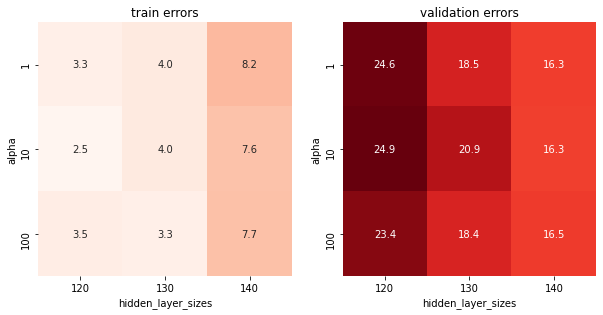

In [58]:

train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=hidden_layer_sizes)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=hidden_layer_sizes)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('hidden_layer_sizes'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('hidden_layer_sizes'); plt.ylabel('alpha');

### b. In các giá trị tốt nhất vừa tìm được

In [59]:
print("best_val_err : ", best_val_err)
print("best_alpha : " ,best_alpha)
print("best_hidden_layer",best_hidden_layer)

best_val_err :  16.25746556466737
best_alpha :  100
best_hidden_layer 130


- Qua mô hình MLPRegresor ta có độ lỗi trên tập validation nhỏ nhất là 15.88%

## 2. Mô hình `RandomforestRegressor`

- Tham số: random_state=0
- Siêu tham số max_depth với 5 giá trị khác nhau.
- Tham số n_estimators với 5 giá trị khác nhau.

Tìm các giá trị best_max_depth, best_n_estimators.

In [60]:
warnings.filterwarnings("ignore")
RandomForest_model = RandomForestRegressor(random_state=0)
RFR_pipeline = make_pipeline(col_adderdropper, col_transform, StandardScaler(), RandomForest_model)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
max_depth = [16, 32, 64, 128, 256]
n_estimators=[20,50,80,100,120,130]
best_val_err = float('inf'); best_max_depth = None; best_n_estimators=None;
for depth in max_depth:
    for estimators in n_estimators:
        RFR_pipeline.set_params(randomforestregressor__max_depth = depth, randomforestregressor__n_estimators = estimators)
        RFR_pipeline.fit(train_X, train_y)
        train_errs.append(100 - compute_rr(train_y, RFR_pipeline.predict(train_X), baseline_preds) * 100)
        val_errs.append(100 - compute_rr(val_y, RFR_pipeline.predict(val_X), baseline_preds) * 100)

        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_max_depth = depth
            best_n_estimators = estimators
            
'Finish!'

'Finish!'

### a. Trực quan hóa kết quả độ lỗi theo các tham số khác nhau trên tập train và tập validation

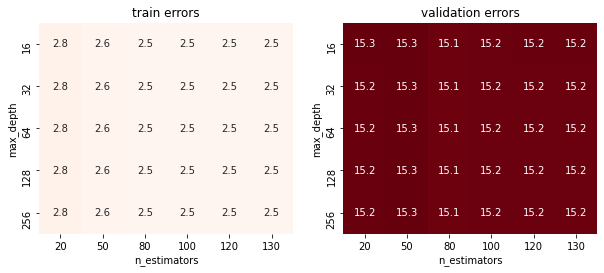

In [61]:
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(max_depth), -1),
                             index=max_depth, columns=n_estimators)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(max_depth), -1), 
                           index=max_depth, columns=n_estimators)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('n_estimators'); plt.ylabel('max_depth')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('n_estimators'); plt.ylabel('max_depth');

### b. In các giá trị tốt nhất vừa tìm được

In [68]:
print("best_val_err : ", best_val_err)
print("best_depth : " ,best_max_depth)
print("best_n_estimator",best_n_estimators)

best_val_err :  15.116219181481853
best_depth :  32
best_n_estimator 80


- Qua mô hình RandomForestRegressor ta có độ lỗi trên tập validation nhỏ nhất là 15.11%

# 3. Đánh giá độ lỗi và chọn mô hình phù hợp cho máy học nâng cao.


- Cả mô hình `RandomForestRegressor` và `MLPRegression` cho kết quả khả quan trên tập validation, tuy nhiên kết quả vẫn còn khá chủ quan vì việc lựa chọn các siêu tham số đều được làm bằng tay.
- Cả 2 mô hình đều chạy khá ổn, tuy nhiên chọn mô hình `randomforestregression` vì kết quả độ lỗi có vẻ tốt hơn.

### a. Train lại bằng mô hình `RandomForestRegressor` với các siêu tham số tối ưu tìm được trên tập train + validation.

In [63]:
warnings.filterwarnings("ignore")
full_train_X_df = train_X.append(val_X)
full_train_y_sr = train_y.append(val_y)

RFR_pipeline.set_params(randomforestregressor__max_depth = best_max_depth, randomforestregressor__n_estimators = best_n_estimators)
RFR_pipeline.fit(full_train_X_df, full_train_y_sr)

Pipeline(memory=None,
         steps=[('coladderdropper', ColAdderDropper()),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('unorder_cate_cols',
                                                  Pipeline(memory=None,
                                                           steps=[('onehotencoder',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unkno...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=

### b. So sánh kết quả predict với kết quả thực trên tập validation

In [64]:
RFR_preds = RFR_pipeline.predict(val_X).round(5)
# So sánh kết quả predict với kết quả actual
RFR_preds_df = pd.DataFrame(RFR_preds, index=val_y.index).rename(columns={0: 'Predict'})
RFR_preds_df = RFR_preds_df.assign(Actual = val_y)
RFR_preds_df.sample(15)

,Predict,Actual
312,48544.07800,48549.17835
236,10794.53549,10825.25370
715,13128.77425,11729.67950
992,11929.61412,11073.17600
919,2164.53502,2196.47320
583,1528.17250,1137.01100
144,3827.63905,3756.62160
210,40507.87700,40273.64550
8,4797.98477,3906.12700
240,11898.01350,10338.93160


### c. Tính độ chính xác trên tập test với mô hình `RandomForestRegressor`

In [65]:
test_df = pd.read_csv('/test.csv')
y_sr_test = test_df["charges"] # sr là viết tắt của series
X_df_test = test_df.drop("charges", axis=1)

In [66]:
RFR_score=compute_rr(y_sr_test, RFR_pipeline.predict(X_df_test), baseline_preds) * 100
print("Độ chính xác: ",RFR_score)


Độ chính xác:  85.03163260852679


# V. Tổng kết

## - Độ chính xác các mô hình trên tập test

In [67]:
print("Độ chính xác")
print("Linear regression:                         ",linear_score)
print("Linear regression sử dụng Gradient Decent: ",GDLR_score)
print("RandomForestRegressor:                     ",RFR_score)

Độ chính xác
Linear regression:                          76.45592517072784
Linear regression sử dụng Gradient Decent:  76.39518336884825
RandomForestRegressor:                      85.03163260852679


#### Kết luận: Vậy qua các mô hình trên, ta tìm được mô hình tốt nhất cho việc huấn luyện cũng như dự đoán. Với mô hình `RandomForestRegressor` cho ra dự đoán với độ chính xác lên đến 85% (khá cao).